<div align='center'><font size="5" color='#353B47'>Introduction to Time Series Analysis</font></div>
<div align='center'><font size="4" color="#353B47">Good practices and forecasting methods</font></div>
<br>
<hr>

**<font color="blue" size="4">What is a Time Series ?</font>**

> A Time Series is a **time-indexed** series of data. In Finance, a time series tracks the movement of the chosen data points, such as a *security’s price*, over a specified period of time with data points recorded at **regular intervals**.

<img src="https://toocooltrafficschool.com/wp-content/uploads/2019/02/what-is-tlsae740.png" width="500">

**<font color="blue" size="4">Why is it used for ?</font>**

> Time series analysis can be useful to see how a given asset, security, or economic variable changes over time. It can also be used to examine how the changes associated with the chosen data point compare to shifts in other variables over the same time period.

> For example, suppose you wanted to analyze a time series of daily closing stock prices for a given stock over a period of one year. You would obtain a list of all the closing prices for the stock from each day for the past year and list them in chronological order. 

# Import libraries

In [2]:
# Regular libraries for data manipulation
import pprint
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Visualization
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tools for time series analysis
from scipy import signal
import statsmodels.api as sm
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_style("whitegrid")
plt.rc('xtick', labelsize=5) 
plt.rc('ytick', labelsize=15)

from pylab import rcParams

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
    --------------------------------------- 10.2/625.1 kB ? eta -:--:--
   -- ------------------------------------ 41.0/625.1 kB 393.8 kB/s eta 0:00:02
   ------- ------------------------------ 122.9/625.1 kB 901.1 kB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------  2.8/2.8 MB 185.7 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 60.6 MB/s eta 0:00:00


# Import data

**<font color="blue" size="4">What is the source of the data ?</font>**

The data is originally imported from a preprocessed dataset I created scrapping <a href="https://markets.businessinsider.com/stocks/air_liquide-stock">this website</a> via *beautifulsoup* library. It is composed of daily stocks of 40 most valuables French Companies (CAC40) from January 2010 to April 2020. 

**For this notebook, I will only focus on Air Liquide Stocks.**

In [4]:
data = pd.read_csv('preprocessed_CAC40.csv', usecols = ['Name','Date','Open','Closing_Price','Daily_High','Daily_Low','Volume'])

In [5]:
data.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [6]:
data.describe()

,Open,Closing_Price,Daily_High,Daily_Low
count,97418.000000,97646.000000,97444.000000,97444.000000
mean,68.737224,68.823124,69.145090,68.357316
std,77.246790,77.267756,77.646032,76.866258
min,3.370000,3.370000,3.410000,3.350000
25%,24.810000,24.840000,24.960000,24.650000
50%,46.880000,46.980000,47.160000,46.640000
75%,81.717500,81.860000,82.220000,81.262500
max,724.000000,724.000000,724.000000,718.000000


In [7]:
# Filter the dataframe on Air Liquide stocks
air_liquide = data[data['Name'] == 'Apple'].copy()

In [8]:
# Converting 'Date' to datetime object
air_liquide['Date'] = pd.to_datetime(air_liquide['Date'])
air_liquide['Year'] = air_liquide['Date'].dt.year
air_liquide['Month'] = air_liquide['Date'].dt.month

In [9]:
print(f'air_liquide shape: {air_liquide.shape[0]} rows, {air_liquide.shape[1]} columns')

air_liquide shape: 0 rows, 9 columns


In [10]:
air_liquide.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Year,Month


In [11]:
# air_liquide=air_liquide[-1300:]

In [12]:
air_liquide.describe()

,Date,Open,Closing_Price,Daily_High,Daily_Low,Year,Month
count,0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaT,NaN,NaN,NaN,NaN,NaN,NaN
min,NaT,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaT,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaT,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaT,NaN,NaN,NaN,NaN,NaN,NaN
max,NaT,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <div id="summary">Summary</div>

**<font size="2"><a href="#chap1">1. Line plot of observations</a></font>**
**<br><font size="2"><a href="#chap2">2. Treatment of missing values</a></font>**
**<br><font size="2"><a href="#chap3">3. Seasonality</a></font>**
**<br><font size="2"><a href="#chap4">4. Time series components</a></font>**
**<br><font size="2"><a href="#chap5">5. Stationarity</a></font>**
**<br><font size="2"><a href="#chap6">6. Autocorrelation</a></font>**
**<br><font size="2"><a href="#chap7">7. Lag Scatter Plot</a></font>**
**<br><font size="2"><a href="#chap8">8. Moving Average</a></font>**
**<br><font size="2"><a href="#chap9">9. Exponential Smoothing</a></font>**
**<br><font size="2"><a href="#chap10">10. Forecasting with Auto ARIMA</a></font>**

# <div id="chap1">1. Line plot of observations</div>

A **line plot** is the a graph that displays data as points or check marks above a number line, showing the frequency of each value. It helps to identify:

* **Outliers** or exagerated values

* **Missing observations** (in most cases an error messages appear)

* **Variation** of the data

* **Seasonality and trend** of the data

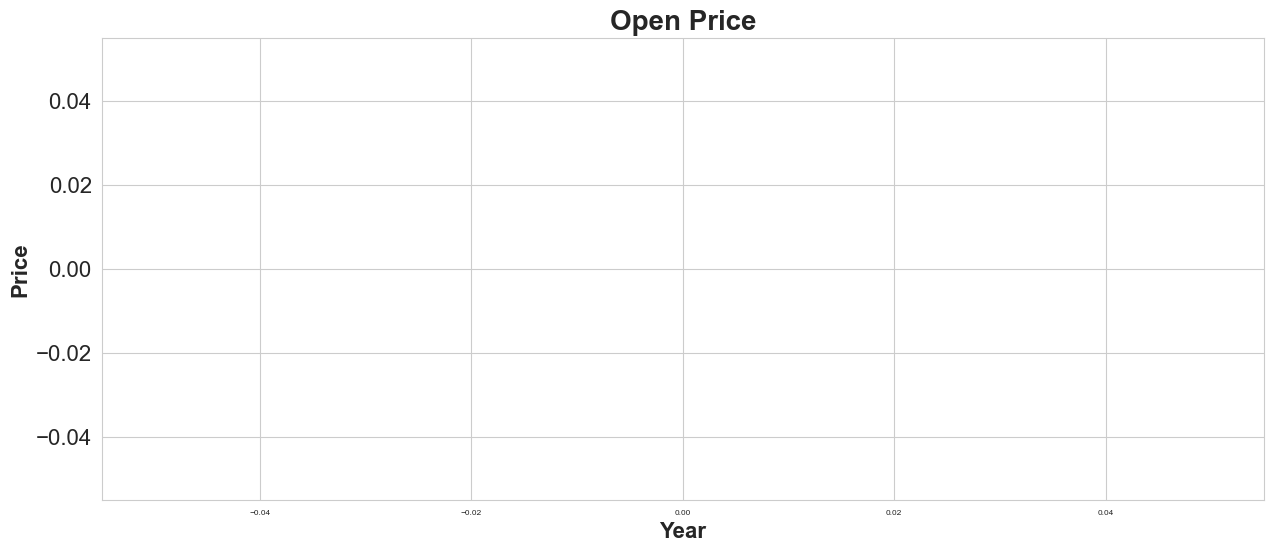

In [15]:
# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=air_liquide, x='Date', y='Open')

# Formatting
ax.set_title('Open Price', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=6)


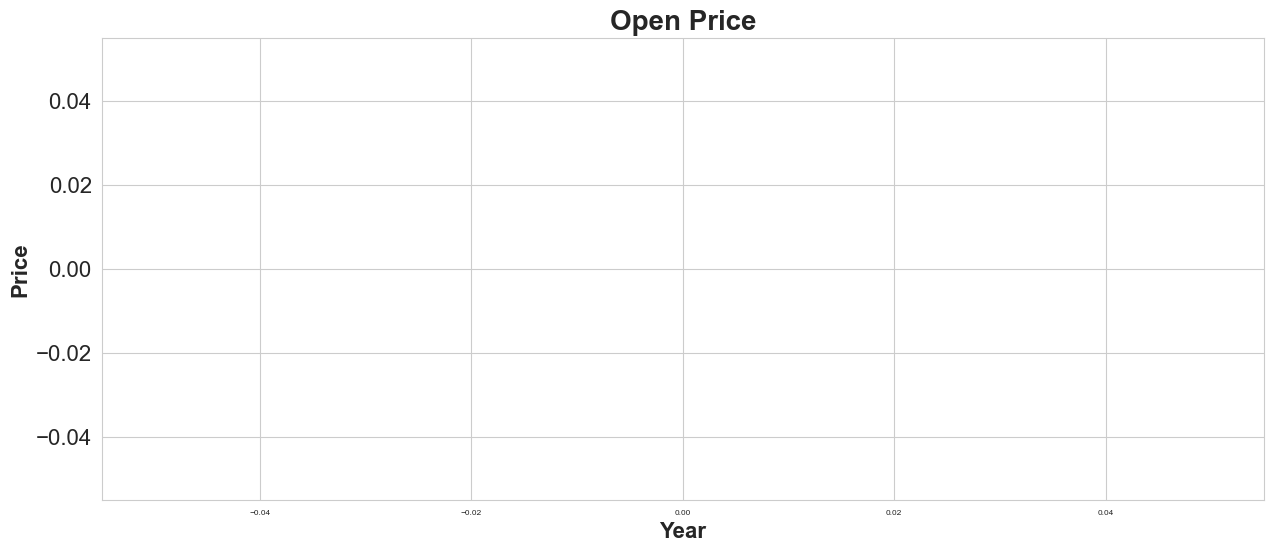

In [14]:
# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
#sns.lineplot(air_liquide['Date'], air_liquide['Open'] )
sns.lineplot(data=air_liquide, x='Date', y='Open')

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=6)

**<font color="blue" size="4">What can we say about Air Liquide stocks ?</font>**

The data **don't seem to show seasonality** within each year. There is rather a **trend** than a **cyclic behavior**. We can see that the price is falling sharply early 2020 due to the COVID19.

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap2">2. Treatment of missing values</div>

Most of the time, the problem must be dealt with on a case-by-case basis. But there are different ways to input missing values:

* **Forward filling and Backward Fill**: Forward filling means fill missing values with previous data. Backward filling means fill missing values with next data point.

* **Linear interpolation**: Method of curve fitting using linear polynomials to construct new data points within the range of a discrete set of known data points.

* **Quadratic interpolation**: Method of curve fitting using non linear polynomials to construct new data points within the range of a discrete set of known data points.

* **Mean of nearest neighbors**

* **Mean of seasonal**

In [16]:
# Let's check NaN 
air_liquide.isna().sum()

Name             0
Date             0
Open             0
Closing_Price    0
Daily_High       0
Daily_Low        0
Volume           0
Year             0
Month            0
dtype: int64

1 missing value in <font color='red'>'Open'</font> column and 134 misising values in <font color='red'>'Volume'</font> column

In [17]:
# # Get index of the missing value in Open column
# index_open_missing = air_liquide[pd.isnull(air_liquide['Open'])].index
# print(list(index_open_missing)[0])

In [18]:
# I replace the missing value by the Open price value of the previous day (backward fill)
air_liquide['Open'] = air_liquide['Open'].fillna(method='bfill')

In [19]:
print(f"Percentage of missing values in Volume: {round(sum(pd.isnull(air_liquide['Volume']))/air_liquide.shape[0],2)}\n")
print(air_liquide[air_liquide['Volume']==0])

ZeroDivisionError: division by zero

Missing values of the <font color='red'>'Volume'</font> column correspond to 5% of observations. Plus, There is no observation for which the value is 0. Let's make the assumption that a missing value corresponds to 0 volume of stocks traded.

In [20]:
# # Imputation
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# air_liquide_plus = imputer.fit_transform(air_liquide)

# # Imputation removed column names; put them back
# imputed_air_liquide = pd.DataFrame(air_liquide_plus)
# imputed_air_liquide.columns = air_liquide.columns

In [21]:
# Replace , by . so Volume can be converted as float
imputed_air_liquide=data.copy()
imputed_air_liquide['Volume'] = imputed_air_liquide['Volume'].apply(lambda x : str(x))
imputed_air_liquide['Volume'] = pd.to_numeric(imputed_air_liquide['Volume'].apply(lambda x : x.replace(',','',1)))

# Convert object to numeric 
imputed_air_liquide['Open'] = pd.to_numeric(imputed_air_liquide['Open'])
imputed_air_liquide['Closing_Price'] = pd.to_numeric(imputed_air_liquide['Closing_Price'])
imputed_air_liquide['Daily_High'] = pd.to_numeric(imputed_air_liquide['Daily_High'])
imputed_air_liquide['Daily_Low'] = pd.to_numeric(imputed_air_liquide['Daily_Low'])

ValueError: Unable to parse string "nan" at position 21

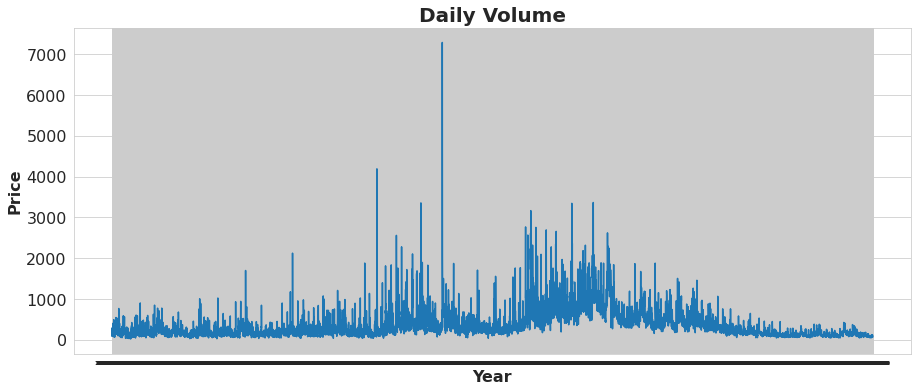

In [18]:
# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(imputed_air_liquide['Date'], imputed_air_liquide['Volume'] )

ax.set_title('Daily Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=6)

There is a lot of noise because I plotted on a daily scale. By chosing the mean of volume traded per month instead of considering the daily volume traded, the graphis likely to be more readable.

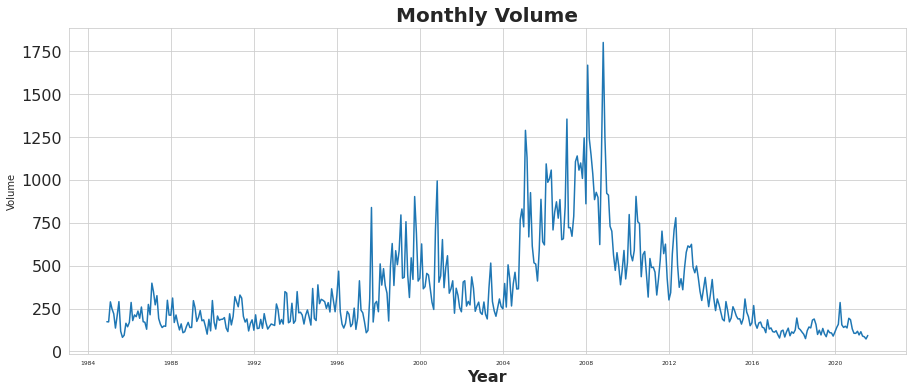

In [19]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Volume']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
y['Date'] = y.index

# Plot the Monthly Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(y['Date'], y['Volume'] )

ax.set_title('Monthly Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=6)

The graph is still noisy but more readable. It's up to you to chose the best period interval and balance the readability/information compromise. 

* **Small period interval**: <font color='red'>Noisy signal</font>, <font color='green'>more information</font>
* **Big period interval**: <font color='green'>Easy to read signal</font>, <font color='red'>loss of information</font>

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap3">3. Seasonality</div>

**<font color="blue" size="4">What is seasonality ?</font>**

In Time Series data, seasonality is the presence of variations that **occur** at **specific regular intervals less than a year**, such as **weekly**, **monthly**, or **quarterly**.

In [20]:
imputed_air_liquide['Date']=pd.to_datetime(imputed_air_liquide['Date'])


In [21]:
imputed_air_liquide['Year'] = imputed_air_liquide['Date'].dt.year
imputed_air_liquide['Month'] = imputed_air_liquide['Date'].dt.month

In [22]:
imputed_air_liquide['Year'].unique()

array([1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021])

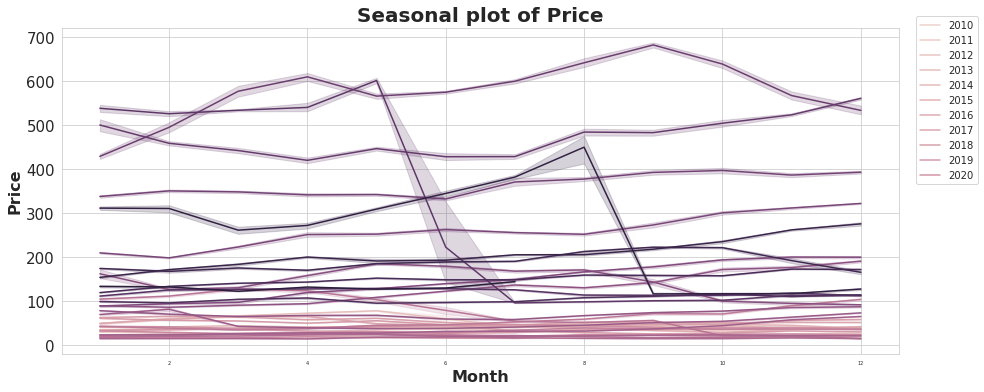

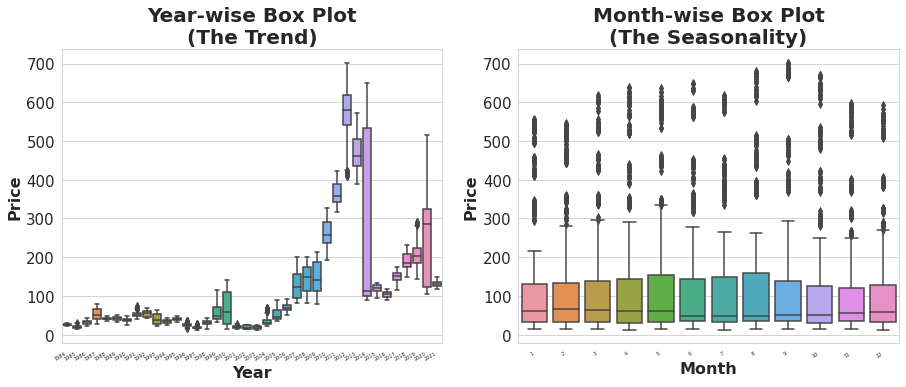

In [23]:
variable = 'Open'
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(imputed_air_liquide['Month'], imputed_air_liquide[variable], hue = imputed_air_liquide['Year'])
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(imputed_air_liquide['Year'], imputed_air_liquide[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(imputed_air_liquide['Month'], imputed_air_liquide[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

fig.autofmt_xdate()

**Seasonal plot of Price**

We can see directly that 2019 was a very good year for the firm. The share price rose from 95 euros to 125 euros. This is the biggest increase over the last 10 years.

**Year wise Box Plot**

Few outliers, no seasonality and an uptrend for the last decade except for 2016. This small slowdown is characterized by the completion of the Airgas acquisition, in 2016, and its first contribution to the Group's performance. You can read the full 2016 report <a href = 'https://www.airliquide.com/sites/airliquide.com/files/2016/07/29/air-liquide-h1-2016-results.pdf'>here</a>

**Month wise Box Plot**

The variance between each class is really small, it shows clearly that there is no effect of seasonality.

<img src = "https://static.vecteezy.com/system/resources/previews/000/126/617/non_2x/vector-tool-box.jpg">

<font color='blue' size='4'>A powerful visualization</font>

<br>On a whole, these plots allow you to:

* Check **seasonal pattern** if it exists
* Identity the **years in which the pattern changes**
* Identify **large jumps or drops**

In the trend and seasonality boxplot:

* Check instantaneously **trend and seasonality**
* Check **outliers**

<font color='blue' size='4'>A powerful visualization you can add to your toolbox</font>

Text(0, 0.5, 'Closing_Price')

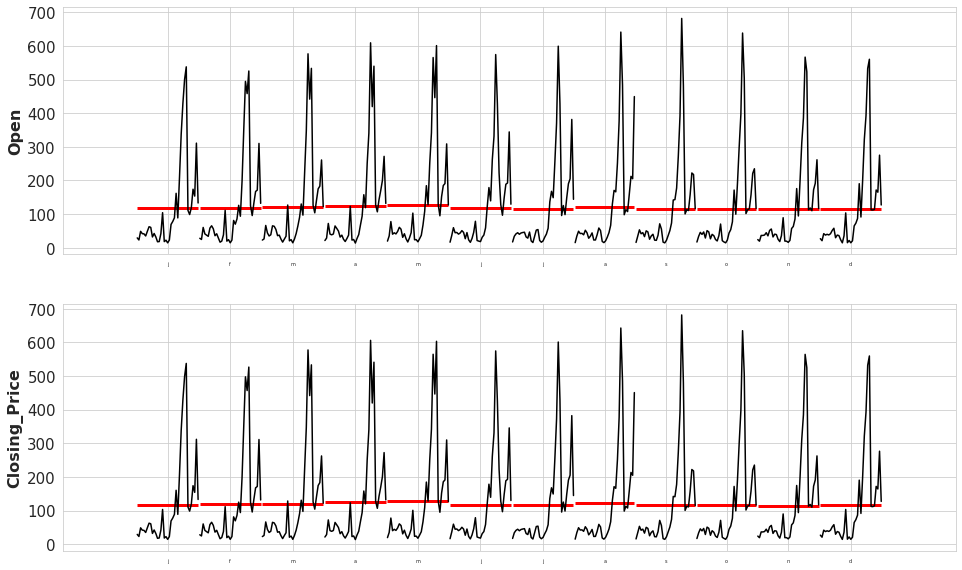

In [24]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open','Closing_Price']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# The magic
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(y['Open'], ax=ax[0]);
ax[0].set_ylabel('Open', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(y['Closing_Price'], ax=ax[1]);
ax[1].set_ylabel('Closing_Price', fontsize = 16, fontdict=dict(weight='bold'))

This graph performs a groupby function to see more clearly the months of seasonality. We can see that there is no seasonality here. The mean of 10 years air liquide open and closing price per month is quite the same.

**<font size="2"><a href="#summary">Back to summary</a></font>**

---

# <div id="chap4">4. Time series components</div>

If we assume an additive decomposition, then we can write

$$y_t = S_t + T_t + R_t$$

where $y_t$ is the data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component and $R_t$ is the residual component, all at period $t$.
Also,for a multiplicative decomposition, we have

$$y_t = S_t * T_t * R_t$$

The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.


Text(0.5, 0.98, 'Open decomposition')

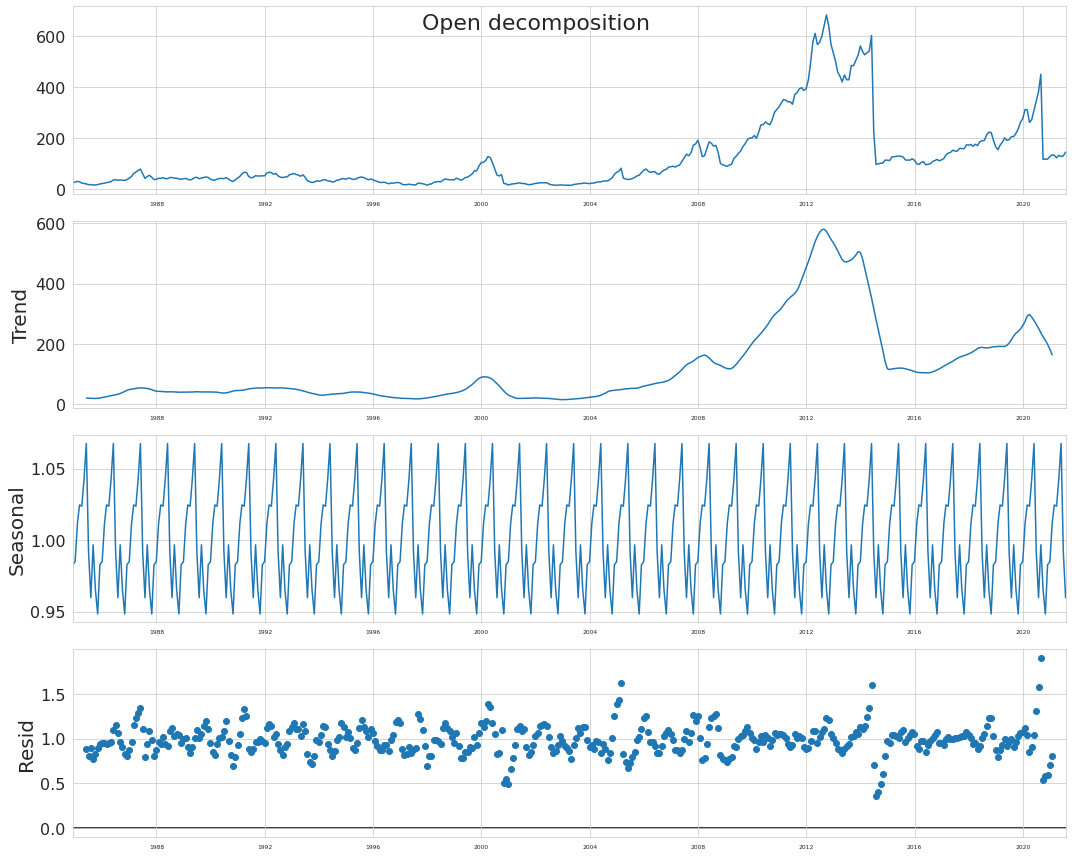

In [25]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Setting rcparams
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 6

# Using statistical tools of statsmodel library
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', freq = 12)
decomp = decomposition.plot()
decomp.suptitle('Open decomposition', fontsize=22)

<font color='blue' size='4'>How to read this ?</font>

<br>The three components are shown separately in the bottom three panels. These components can be multiplied together to reconstruct the data shown in the top panel. We can see that the seasonal component changes slowly over time. But this doesn't mean years far apart won't have different seasonal patterns.

The residual component shown in the bottom panel is what is left over when the seasonal and trend-cycle components have been subtracted from the data.

If the seasonal component is removed from the original data, the resulting values are the “seasonally adjusted” data. For an additive decomposition, the seasonally adjusted data are given by $y_t - S_t$, and for multiplicative data, the seasonally adjusted values are obtained using $y_t / S_t$.

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap5">5. Stationarity</div>

<font color='blue' size='4'>What describes best stationarity ?</font>

<br>A stationary Time Series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary 

A time series with cyclic behavior (but with no trend or seasonality) is stationary.

<font color='blue' size='4'>What is stationarity used for ?</font>

<br>Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary. Forecasting a stationary series is relatively easier and the forecasts are more reliable.

We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors (lags of the series) in the forecasting models nearly independent.

<font color='blue' size='4'>Really interesting, but how to make a Time Series stationary ?</font>

<br>Well, several ways exist:

* Difference the series once or more times (subtracting the next value by the current value)

* Take the log of the series (helps to stabilize the variance of a time series.)

* Take the $n_{th}$ root of the series

* Combinations of the above

But first, to test if a time series is stationary we can:

* Look at the time plot.

* Split the series into 2 parts and compute descriptive statistics. If they differ, then it is not stationary.

* Perform statistical tests called Unit Root Tests like Augmented Dickey Fuller test (ADF Test), Kwiatkowski-Phillips-Schmidt-Shin — KPSS test (trend stationary), and Philips Perron test (PP Test).

The most commonly used is the ADF test, where the null hypothesis is that the time series possesses a unit root (or random walk with drift) and is non-stationary. So, if the P-Value in ADF test is less than the significance level (0.05), you reject the null hypothesis and the series is stationary.

In [26]:
# check for stationarity
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['Open'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.468075
p-value                   0.123437
# lags used               1.000000
# observations          439.000000
critical value (1%)      -3.445334
critical value (5%)      -2.868146
critical value (10%)     -2.570289
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


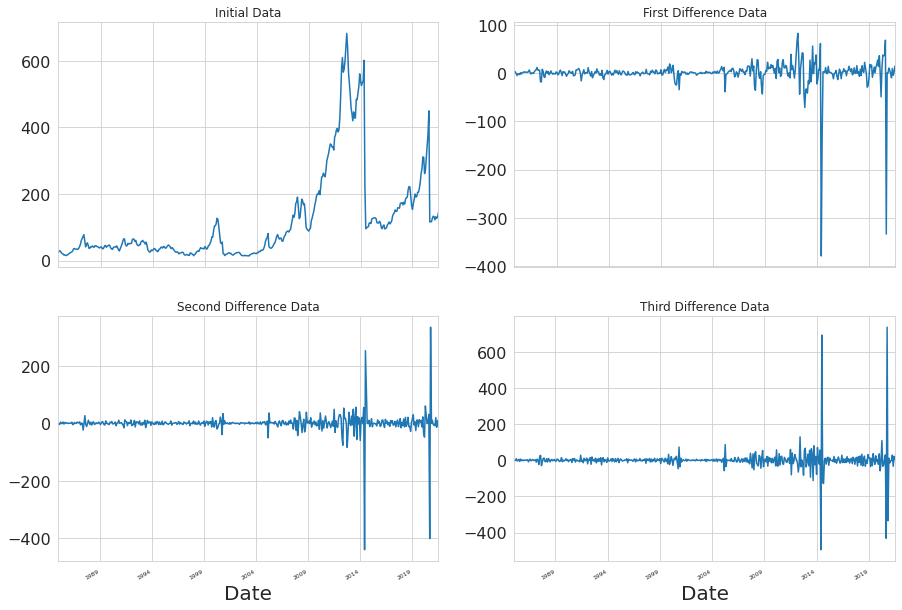

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 11))

y['OpenDiff1'] = diff(y['Open'],k_diff=1)
y['OpenDiff2'] = diff(y['Open'],k_diff=2)
y['OpenDiff3'] = diff(y['Open'],k_diff=3)

y['Open'].plot(title="Initial Data",ax=ax[0][0]).autoscale(axis='x',tight=True);
y['OpenDiff1'].plot(title="First Difference Data",ax=ax[0][1]).autoscale(axis='x',tight=True);
y['OpenDiff2'].plot(title="Second Difference Data",ax=ax[1][0]).autoscale(axis='x',tight=True);
y['OpenDiff3'].plot(title="Third Difference Data",ax=ax[1][1]).autoscale(axis='x',tight=True);

fig.autofmt_xdate()

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap6">6. Autocorrelation</div>

<font color='blue' size='4'>Correlation, Autocorrelation, Partial Autocorrelation ? It looks like all the same, what is the difference ?</font>

<br>**Correlation** measures the extent of a linear relationship between two variables.

**Autocorrelation** measures the linear relationship between lagged values of a time series, for example between $y_t$ and $y_{t-1}$. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

![](http://)**Partial autocorrelations** measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag **k** is the autocorrelation between $y_t$ and $y_{t} + y_{t+k}$ that is not accounted for by lags 1 through k−1. 

We essentially plot out the relationship between the previous day’s/month’s residuals versus the real values of the current day. In general, we expect the partial autocorrelation to drop off quite quickly.

[1.         0.99833545 0.99675079 0.99518412 0.99366311 0.99203567
 0.99043812 0.98890033 0.98741453 0.98597294 0.98454107 0.98310577
 0.9816813  0.98026695 0.97885019 0.97741361 0.97596937 0.97454886
 0.97315299 0.97174203 0.97033303 0.9689363  0.96759938 0.96625209
 0.96495808 0.96363583 0.96232934 0.96095476 0.95956433 0.95820635
 0.95690027 0.95557265 0.95437339 0.95311431 0.95192703 0.95070453
 0.94951556 0.94831862 0.94717902 0.94602014 0.94485382 0.94372261
 0.94258793 0.94147221 0.94032497 0.93916206 0.93799273 0.93681935
 0.93564964 0.93450377 0.93335399 0.93214803 0.9309554  0.92974104
 0.92859776 0.92742325 0.92624894 0.92510554 0.92398715 0.92285476
 0.92169302]


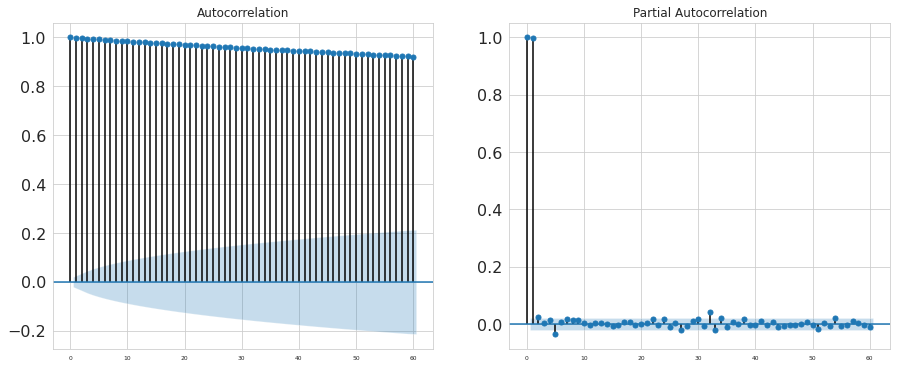

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))
autocorr = acf(imputed_air_liquide['Open'], nlags=60, fft=False)
print(autocorr)

plot_acf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[0], fft=False);
plot_pacf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[1]);

For autocorrelation, the y-axis is the value for the correlation between a value and its lag. The lag is on the x-axis. The zero-lag has a correlation of 1 because it correlates with itself perfectly. 

The autocorrelation plot shows that most of the spikes are not statistically significant. This indicates that the returns are not highly correlated, as shown here.

**<font size="2"><a href="#summary">Back to summary</a></font>**

-----

# <div id="chap7">7. Lag Scatter Plot</div>

<font color='blue' size='4'>Definition</font>

<br>A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot.
It plots the observation at time t on the x-axis and the lag1 observation (t-1) on the y-axis.

* If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a **positive correlation** relationship.

* If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a **negative correlation** relationship.

* Either relationship is good as they can be modeled.

* More points tighter into the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship.

* A ball in the middle or a spread across the plot suggests a weak or no relationship.

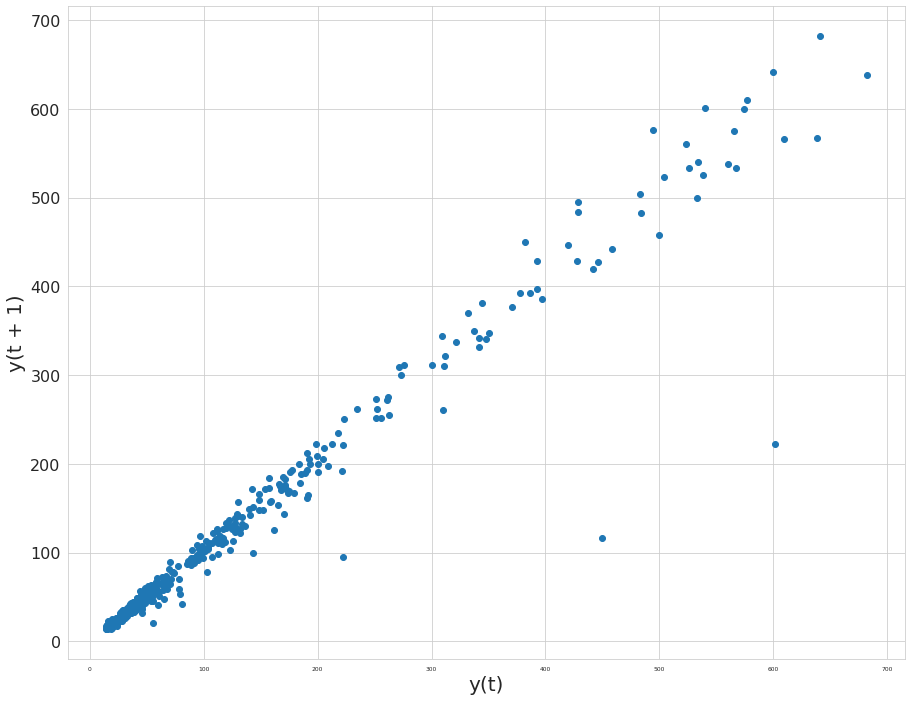

In [29]:
lag_plot(y['Open']);

Here we have a **positive correlation** relationship.

**<font size="2"><a href="#summary">Back to summary</a></font>**

---

# <div id="chap8">8. Moving Average (MA)</div>

<font color='blue' size='4'>The maths behind MA</font>

<br>Moving average is the estimation of the trend-cycle at time t, and is obtained by averaging the values of the time series within k periods of t. Observations that are nearby in time are also likely to be close in value. Therefore, the average eliminates some of the randomness in the data, leaving a smooth trend-cycle component.

It can be written as

$$ \hat{T_t} = \frac{1}{m}\sum_{j=-k}^{k}y_{t+j}$$

where $m = 2k + 1$. That is, the estimate of the trend-cycle at time $t$ is obtained by averaging values of the time series within k periods of $t$.

* Smaller windows will lead to more noise.

* It will always lag by the size of the window.

* It will never reach the full peak or valley of the data due to the averaging.

* It does not really inform you about possible future behavior, all it really does is describe trends in your data.

* Extreme historical values can skew MA significantly.

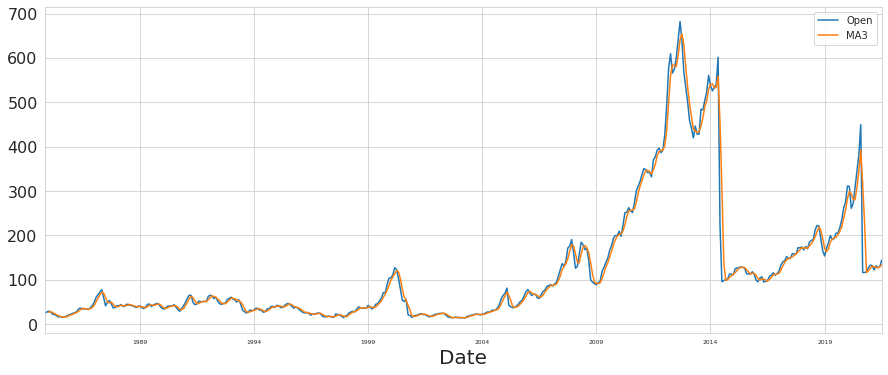

In [30]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

y['MA3'] = y.rolling(window=3).mean() 
y.plot(figsize=(15,6));

**<font size="2"><a href="#summary">Back to summary</a></font>**

---

# <div id="chap9">9. Exponential Smoothing</div>

Exponential smoothing assigns **exponentially decreasing weights** for **newest** to **oldest** observations. In other words, the older the data, the less priority (“weight”) the data is given. Newer data is seen as more relevant and is assigned more weight. Smoothing parameters usually denoted by $\alpha$ ( $0<\alpha\leq1$) determine the weights for observations. Exponential smoothing is usually used to make **short term forecasts**, as longer term forecasts using this technique **can be quite unreliable**.

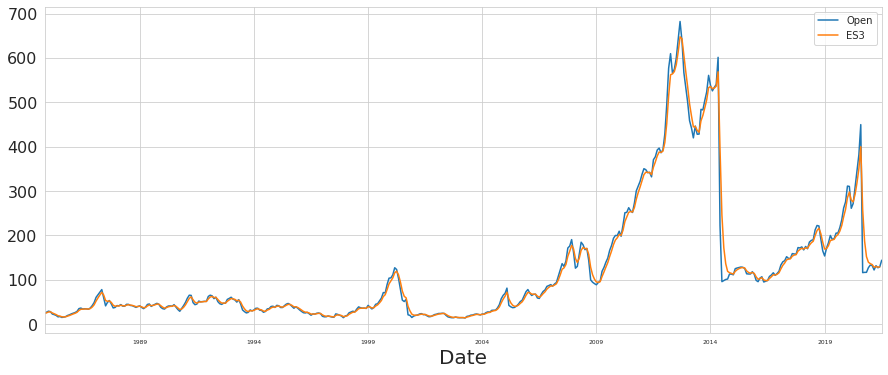

In [31]:
# Setting parameters value
span = 3
# Weights of observations
alpha = 2/(span+1)

# Plot Simple exponential smoothing
y['ES3'] = SimpleExpSmoothing(y['Open']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)
y[['Open','ES3']].plot(figsize=(15,6));

<font color='blue' size='4'>Simple, Double, Triple exponential Smoothing ?</font>

<br>**Simple Exponential Smoothing** employs a **weighted moving average with exponentially decreasing weights**.

**Double Exponential Smoothing** adds a second smoothing factor $\beta$ ($0<\beta\leq1$) that addresses trends in the data. The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations. We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an additive adjustment. If the time series displays an exponential (curved) trend, you would use a multiplicative adjustment.

**Triple Exponential Smoothing** (also called the Multiplicative Holt-Winters), the method is usually more reliable for parabolic trends or data that shows trends and seasonality.

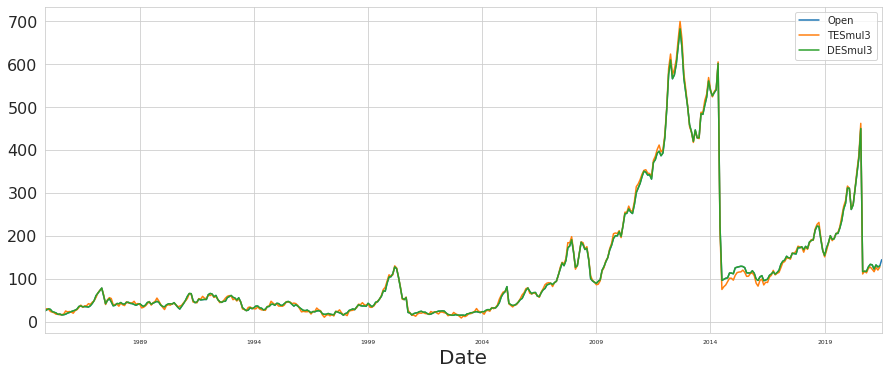

In [32]:
# Plot Double and Triple exponential smoothing
y['DESmul3'] = ExponentialSmoothing(y['Open'], trend = 'add').fit().fittedvalues.shift(-1)
y['TESmul3'] = ExponentialSmoothing(y['Open'], trend = 'add', seasonal = 'add', seasonal_periods = 12).fit().fittedvalues.shift(-1)
y[['Open', 'TESmul3', 'DESmul3']].plot(figsize = (15,6));

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap10">10. Forecasting with Auto ARIMA</div>

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

In [33]:
# Reverse index so the dataframe is from oldest to newest values
imputed_air_liquide = imputed_air_liquide.reindex(index=imputed_air_liquide.index[::])

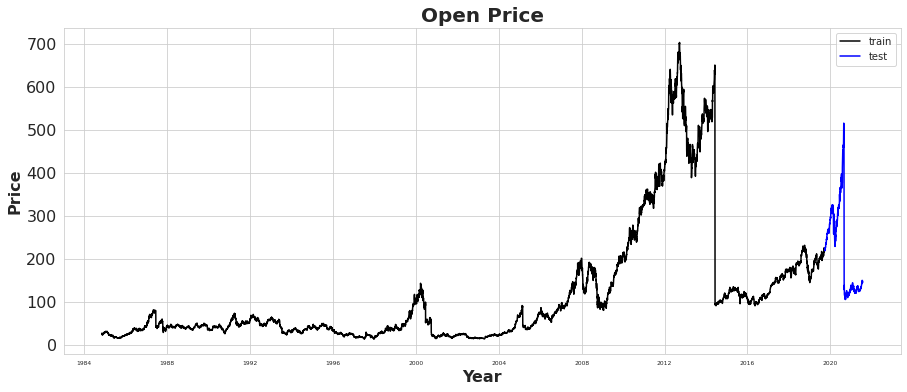

In [34]:
# Split data into train and validation set 90/10
air_liquide_train, air_liquide_val = imputed_air_liquide[:int(len(imputed_air_liquide)*0.95)], imputed_air_liquide[int(len(imputed_air_liquide)*0.95):]

# Index disappeared, put them back
air_liquide_val = air_liquide_val.set_index('Date', drop=False)
air_liquide_train = air_liquide_train.set_index('Date', drop=False)

# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(air_liquide_train['Date'], air_liquide_train['Open'], color = 'black')
sns.lineplot(air_liquide_val['Date'], air_liquide_val['Open'], color = 'blue')

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=6)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.
The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [35]:
%%time
model_autoARIMA = auto_arima(air_liquide_train['Open'])

""", 
                             start_p = 0, 
                             start_q = 0,
                             test = 'adf', # use adftest to find optimal 'd'
                             max_p = 3,
                             max_q = 3, # maximum p and q
                             m = 7, # frequency of series
                             seasonal = False,
                             start_P = 0, 
                             D = 0, 
                             trace = True,
                             error_action = 'ignore',  
                             stepwise = True
"""

print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8791
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -29500.161
Date:                Thu, 29 Jul 2021   AIC                          59008.321
Time:                        17:00:09   BIC                          59036.647
Sample:                             0   HQIC                         59017.971
                               - 8791                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9856      0.015    -64.755      0.000      -1.015      -0.956
ma.L1          0.9575      0.016     58.469      0.000       0.925       0.990
ma.L2         -0.0230      0.007     -3.363      0.0

In comment, you can see the parameters is used according to the documentation and the Time Series I have. However I wasn't really satisfied by the prediction (The best model was a ARMA(1,1) whose were decreasing whereas the trend is increasing since last 10 years.
Tbh, I got some difficulties tuning up this model, I guess <a href='https://alkaline-ml.com/pmdarima/tips_and_tricks.html'>this</a> could help, If you have any suggestions of a right way to do it, don't hesitate to add a comment, I would really appreciate.

Next, create an ARIMA model with provided optimal parameters p, d and q.

In [36]:
model = ARIMA(air_liquide_train['Open'], order = (1, 1, 2))
# disp=-1: no output
fitted = model.fit(disp = -1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 8790
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -29502.333
Method:                       css-mle   S.D. of innovations              6.941
Date:                Thu, 29 Jul 2021   AIC                          59014.666
Time:                        17:00:13   BIC                          59050.073
Sample:                             1   HQIC                         59026.729
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0219      0.057      0.381      0.703      -0.091       0.134
ar.L1.D.Open     0.9880      0.013     77.881      0.000       0.963       1.013
ma.L1.D.Open    -1.0170      0.017    -61.27

Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

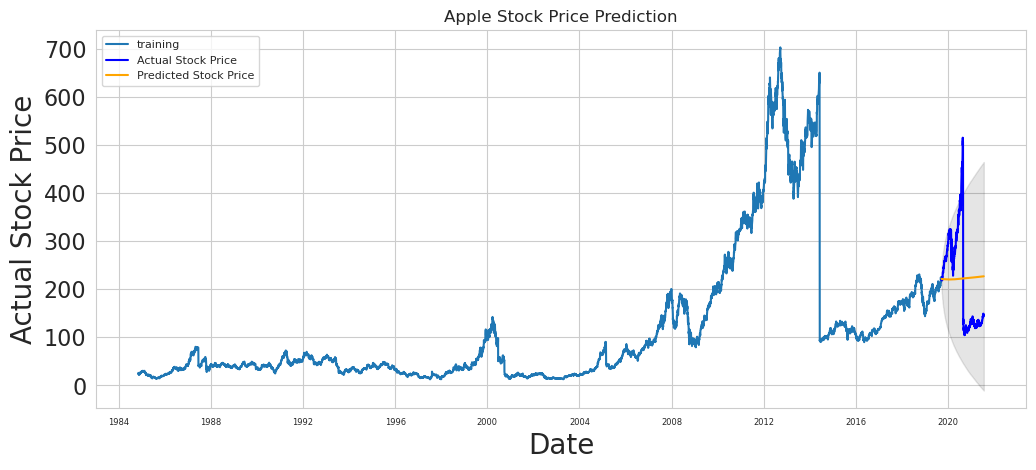

In [37]:
# Forecast 260 next observations 
fc, se, conf = fitted.forecast(463, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=air_liquide_val.index)
lower_series = pd.Series(conf[:, 0], index=air_liquide_val.index)
upper_series = pd.Series(conf[:, 1], index=air_liquide_val.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(air_liquide_train['Open'], label='training')
plt.plot(air_liquide_val['Open'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As you can see our model did quite handsomely. Let us also check the commonly used accuracy metrics to judge forecast results:

In [38]:
import math

In [39]:
# Report performance
mse = mean_squared_error(air_liquide_val['Open'], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(air_liquide_val['Open'], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(air_liquide_val['Open'], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - air_liquide_val['Open'])/np.abs(air_liquide_val['Open']))
print('MAPE: '+str(mape))

MSE: 10796.515601889852
MAE: 92.72690939408079
RMSE: 103.90628278352494
MAPE: 0.5138137591654668


Around 11% MAPE(Mean Absolute Percentage Error) implies the model is about 89% accurate in predicting the test set observations. End to end, the value is close. However, the model could not predict the higher than normal growth for the past year, but it couldn't predict the covid19 crisis which involved a decreased in Open prices.

**<font size="2"><a href="#summary">Back to summary</a></font>**

---

# References

* https://www.machinelearningplus.com/time-series/time-series-analysis-python/

* https://www.udemy.com/python-for-time-series-data-analysis/

* https://machinelearningmastery.com/time-series-data-visualization-with-python/

* https://www.statisticshowto.com/exponential-smoothing/

* https://otexts.com/fpp2/components.html

<hr>
<br>
<div align='justify'><font color="#353B47" size="4">Thank you for taking the time to read this notebook. I hope that I was able to answer your questions or your curiosity and that it was quite understandable. <u>any constructive comments are welcome</u>. They help me progress and motivate me to share better quality content. I am above all a passionate person who tries to advance my knowledge but also that of others. If you liked it, feel free to <u>upvote and share my work.</u> </font></div>
<br>
<div align='center'><font color="#353B47" size="3">Thank you and may passion guide you.</font></div>